<a href="https://colab.research.google.com/github/reneroliveira/Statistical_Modeling/blob/main/Bayesian%20Linear%20Regression/BayesianLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Linear Regression with PyMC3
<author> **Rener Oliveira** </author>

In [ ]:
# !pip install arviz==0.8.3
# !pip install pymc3==3.8
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import statsmodels.api as sm
from statsmodels.tools import add_constant
from pymc3 import *
import scipy as sp
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
import seaborn as sns
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.8


In [ ]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0) #for reproducibility
sp.random.seed(0)

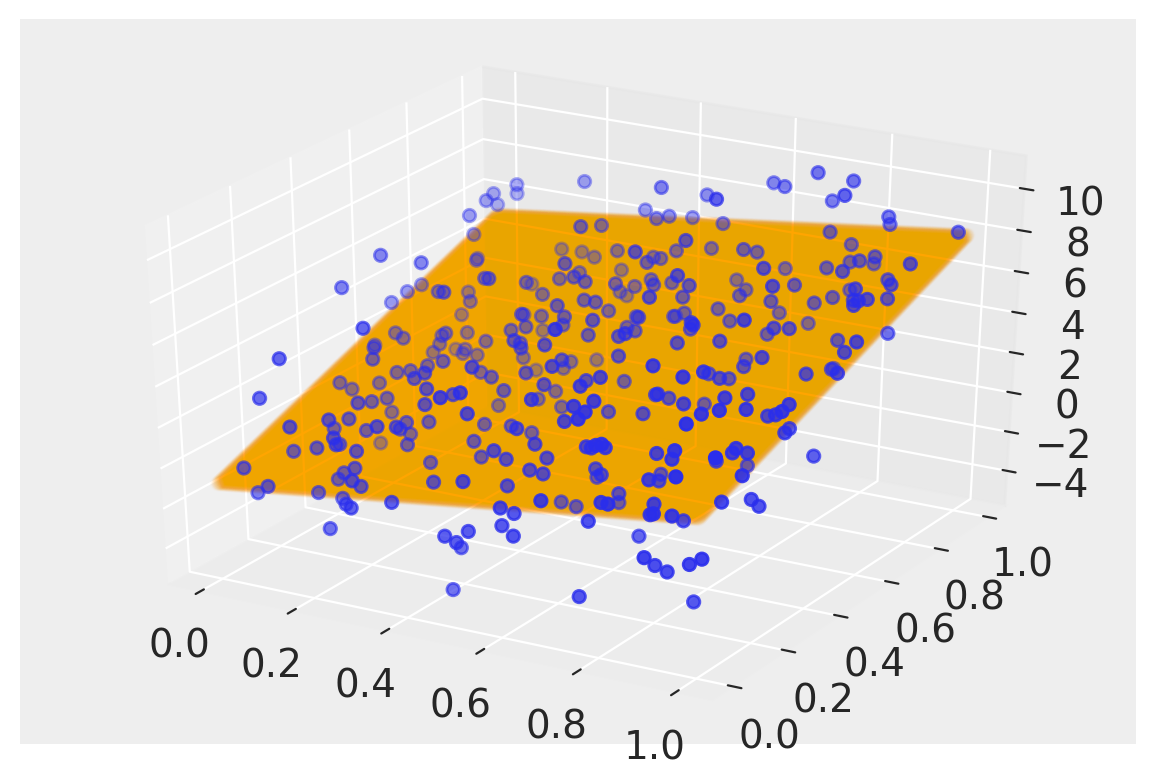

In [ ]:
n = 350

true_beta = [-1,3,6]
true_sigma2 = 2**2
X1 = np.linspace(0,1,n)
X2 = np.random.uniform(size = n)

# y = beta0+beta1*x1+beta2*x2
true_regression_plane = true_beta[0] + true_beta[1] * X1 + true_beta[2]*X2

# Adding Noise with variance true_sigma2
y = true_regression_plane + norm(scale=true_sigma2**(1/2)).rvs(size=n)#,random_state=0)

# Agregating data
D = dict(X1=X1,X2=X2, y=y)

# 3D Plot
fig = plt.figure()
ax = plt.axes(projection='3d')

xx, yy = np.meshgrid(np.linspace(0,1,n), np.linspace(0,1,n))
ax.scatter3D(xx,yy,true_beta[0] + true_beta[1] * xx + 1*true_beta[2]*yy,color="orange",alpha=0.02)
ax.scatter3D(X1,X2,y)
plt.savefig("generated_data.png")
plt.show();

## Frequentist Approach - Ordinary Least Squares Estimators

In [ ]:
X = add_constant(np.c_[D['X1'],D['X2']])
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     170.7
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           2.38e-52
Time:                        21:08:48   Log-Likelihood:                -739.93
No. Observations:                 350   AIC:                             1486.
Df Residuals:                     347   BIC:                             1497.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2781      0.288     -4.434      0.0

In [ ]:
# print(results.summary().as_latex())

## Bayesian Linear Model with Conjugate Priors

The problem likelihood setup is, 

$$y_i|\boldsymbol x_i,\beta,\sigma^2\overset{\text{iid}}{\sim}\mathcal{N}(\boldsymbol x_i\beta,\sigma^2),$$

where $y_i$ is the $i$-th target value, $\boldsymbol x_i$ is a line vector of predictors values, $\beta$ is a column vector of coefficients and $\sigma^2$ is the variance.

It can be shown that the following distributions are joint conjugate priors for $(\beta,\sigma^2)$:

\begin{align*}\sigma^2& \overset{\text{iid}}{\sim}\operatorname{Inv-Gamma}(a_0,b_0)\\
		\beta|\sigma^2&\overset{\text{iid}}{\sim} \mathcal{N}(\boldsymbol\mu_0,\sigma^2\boldsymbol\Lambda_0^{-1})
    \end{align*}

where $\boldsymbol\Lambda_0$ being a prior precision matrix. The corresponding posteriors are:

\begin{align*}\sigma^2|\boldsymbol y,\boldsymbol X&\sim \operatorname{Inv-Gamma}(a_n,b_n)\\ \beta|\sigma^2,\boldsymbol y,\boldsymbol X &\sim \mathcal{N}(\boldsymbol\mu_n,\sigma^2\boldsymbol\Lambda_n^{-1}),
		\end{align*}

with $\boldsymbol y$ being the target column vetor and $\boldsymbol X$ the predictors design matrix. The update is given by the following formulas:

\begin{align*}
		\boldsymbol\mu_n&=(\boldsymbol X^T\boldsymbol X+\boldsymbol\Lambda_0)^{-1}(\boldsymbol X^T\boldsymbol X\hat\beta+\boldsymbol\Lambda\boldsymbol\mu_0)\\
		\boldsymbol\Lambda_n&=\boldsymbol X^T \boldsymbol X+\boldsymbol\Lambda_0\\
		a_n&=a_0+\dfrac{n}{2}\\
		b_n&=b_0+\dfrac{\boldsymbol y^T\boldsymbol y-\boldsymbol \mu_n^T\boldsymbol\Lambda_n\boldsymbol\mu_ n+\boldsymbol\mu_0^T\boldsymbol\Lambda_0\boldsymbol\mu_0}{2}
	\end{align*}

We're going to do a numerical posterior sampling with PyMC3 and compare results with OLS estimators.



### Priors

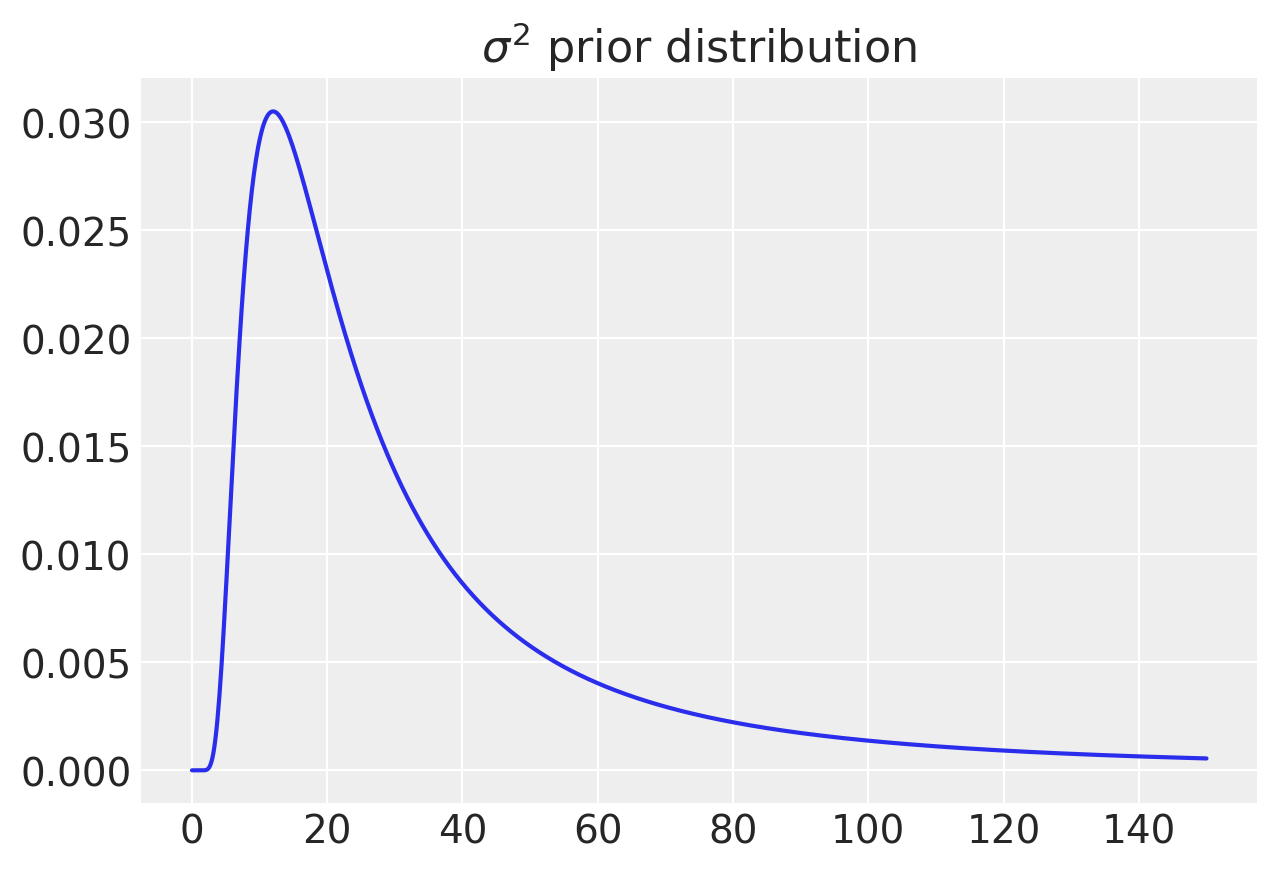

In [ ]:
# Prior parameters (non-informative)
v0 = 3
s02 = 20
a0 = v0/2
b0 = v0*s02/2

mu0 = np.zeros(3)
Lambda0 = 0.01*np.eye(3)

# sigma2 prior plot
xaxis = np.linspace(0.0001,150,1000)
fig,ax = plt.subplots(1,1)
ax.set_title(r"$\sigma^2$ prior distribution")
ax.plot(xaxis,invgamma.pdf(xaxis, a=a0, scale=b0))
plt.savefig("sigma2_prior.png")

### Posterior Sampling with Normal-Inverse-Gamma random variables

In [ ]:
def update_parameters(X,y,a0,b0,mu0,Lambda0):
  beta_hat = np.linalg.solve(X.T@X,X.T@y)
  mu_n = np.linalg.solve(X.T@X+Lambda0,X.T@X@beta_hat+Lambda0@mu0)
  Lambda_n = X.T@X+Lambda0
  a_n = a0+n/2
  b_n = b0 + (y.T@y-mu_n.T@Lambda_n@mu_n+mu0.T@Lambda0@mu0)/2
  return dict(a_n=a_n,
              b_n=b_n,
              mu_n=mu_n,
              Lambda_n=Lambda_n)

posterior = update_parameters(X,y,a0,b0,mu0,Lambda0)
a_n,b_n,mu_n,Lambda_n = posterior.values()
[np.round(x,4) for x in (a_n,b_n,mu_n,Lambda_n)]

[176.5,
 733.0766,
 array([-1.2762,  2.5898,  6.4903]),
 array([[350.01  , 175.    , 171.882 ],
        [175.    , 116.8438,  84.4265],
        [171.882 ,  84.4265, 113.7668]])]

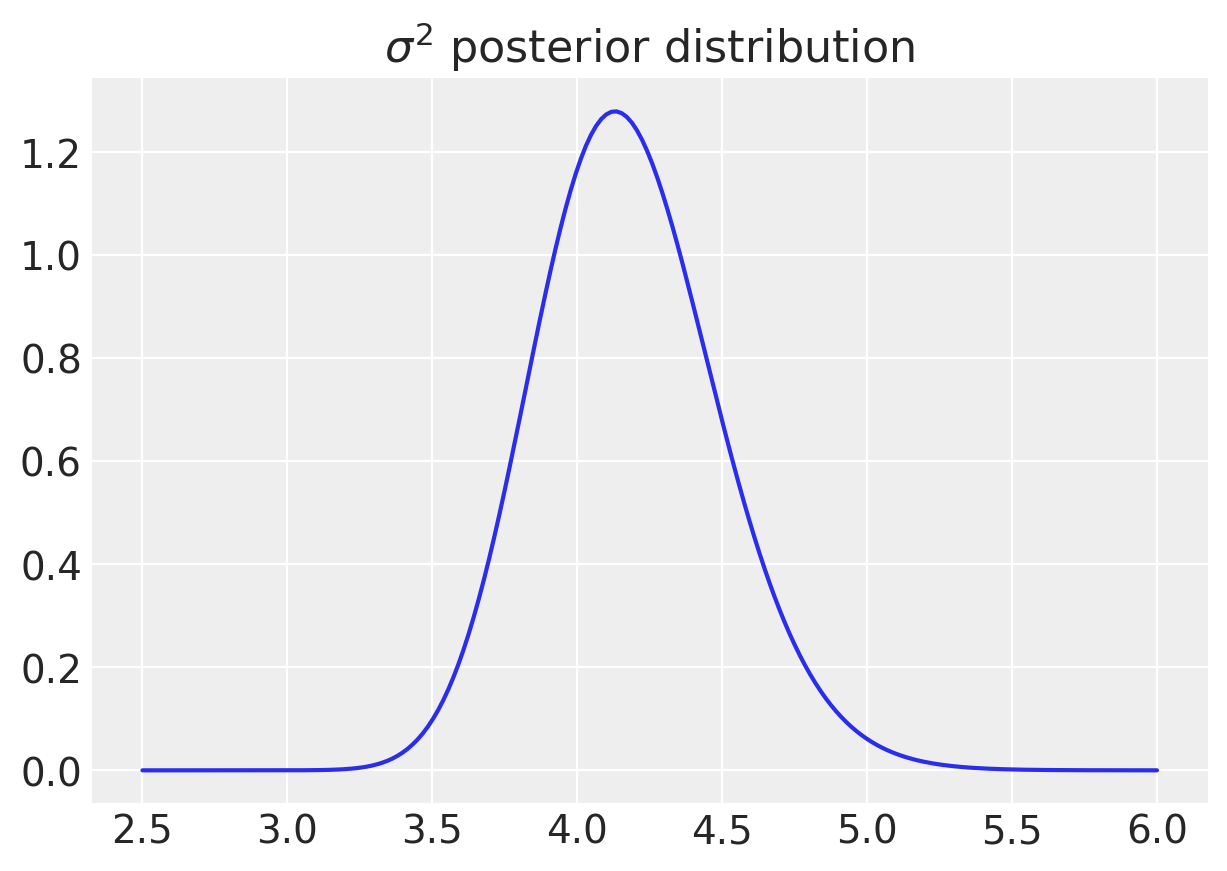

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_title(r"$\sigma^2$ posterior distribution")
xaxis = np.linspace(2.5,6,200)
ax.plot(xaxis,invgamma.pdf(xaxis, a=a_n, scale=b_n))
plt.savefig("sigma2_posterior.png")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

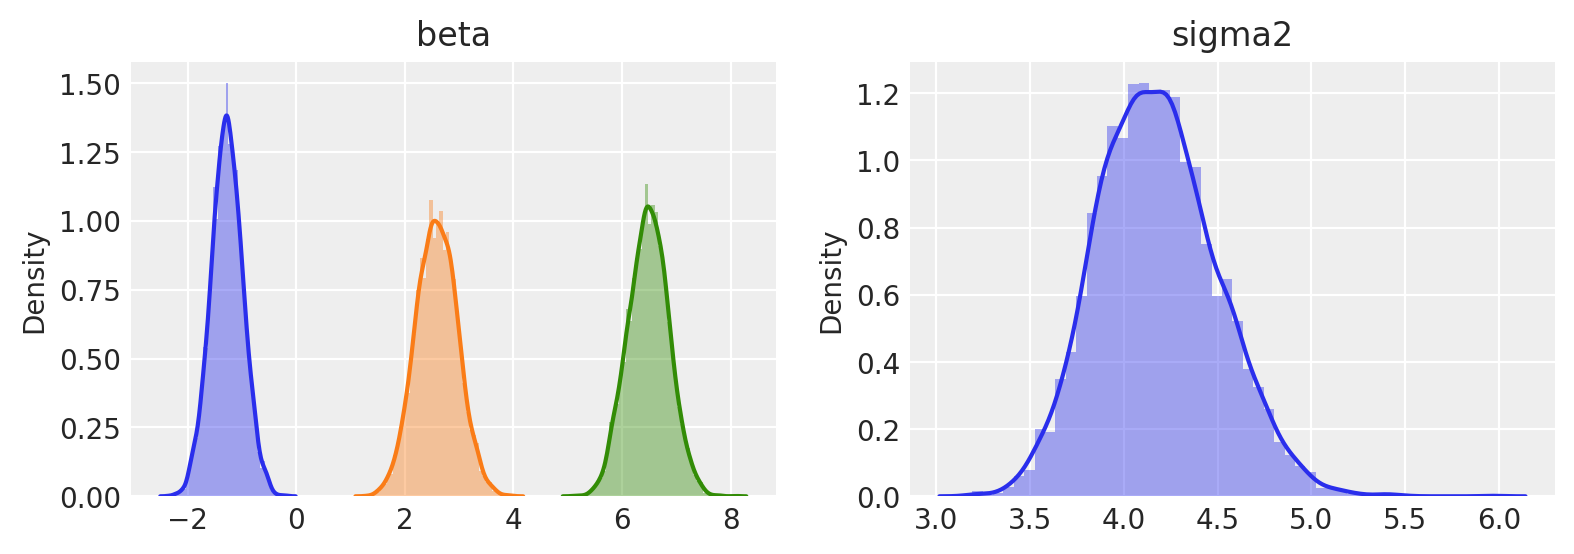

In [ ]:
def posterior_invgamma(a_n,b_n,size=200):
  return invgamma.rvs(a=a_n, scale=b_n,size=size)
def posterior_normal(mu_n,Lambda_n,sigma2):
  sample = []
  cov = np.linalg.inv(Lambda_n)
  for s2 in sigma2:
    sample.append(multivariate_normal.rvs(mean=mu_n,cov=s2*cov))
  return np.array(sample)
  
sigma2 = posterior_invgamma(a_n,b_n,size=5000)
beta = posterior_normal(mu_n,Lambda_n,sigma2)
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].set_title("beta")

sns.distplot(beta[:,0],ax=ax[0])
sns.distplot(beta[:,1],ax=ax[0])
sns.distplot(beta[:,2],ax=ax[0])

ax[1].set_title("sigma2")
sns.distplot(sigma2,ax=ax[1])
fig.tight_layout(pad=1.5)

plt.savefig("posterior_sampling.png")

#### Markov Chain Monte Carlo Estimation

In [ ]:
# MCMC estimation
with Model() as model:  
    # Priors
    sigma2 = InverseGamma("sigma2",alpha=a0,beta=b0)
    beta = MvNormal("beta",mu=mu0,cov=sigma2*pm.math.matrix_inverse(Lambda0),shape=(3))

    # Likelihood
    likelihood = Normal("y", mu=beta[0] + beta[1] * X1 + beta[2]*X2, sigma=sigma2**(1/2), observed=y)
    # likelihood = Normal("y", mu=beta[0] + beta[1]*x1, sigma=sigma2**(1/2), observed=y)

    trace = sample(5000, cores=4,tune=1000)  # NUTS sampler

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma2]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [02:11<00:00, 182.77draws/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 700x700 with 0 Axes>

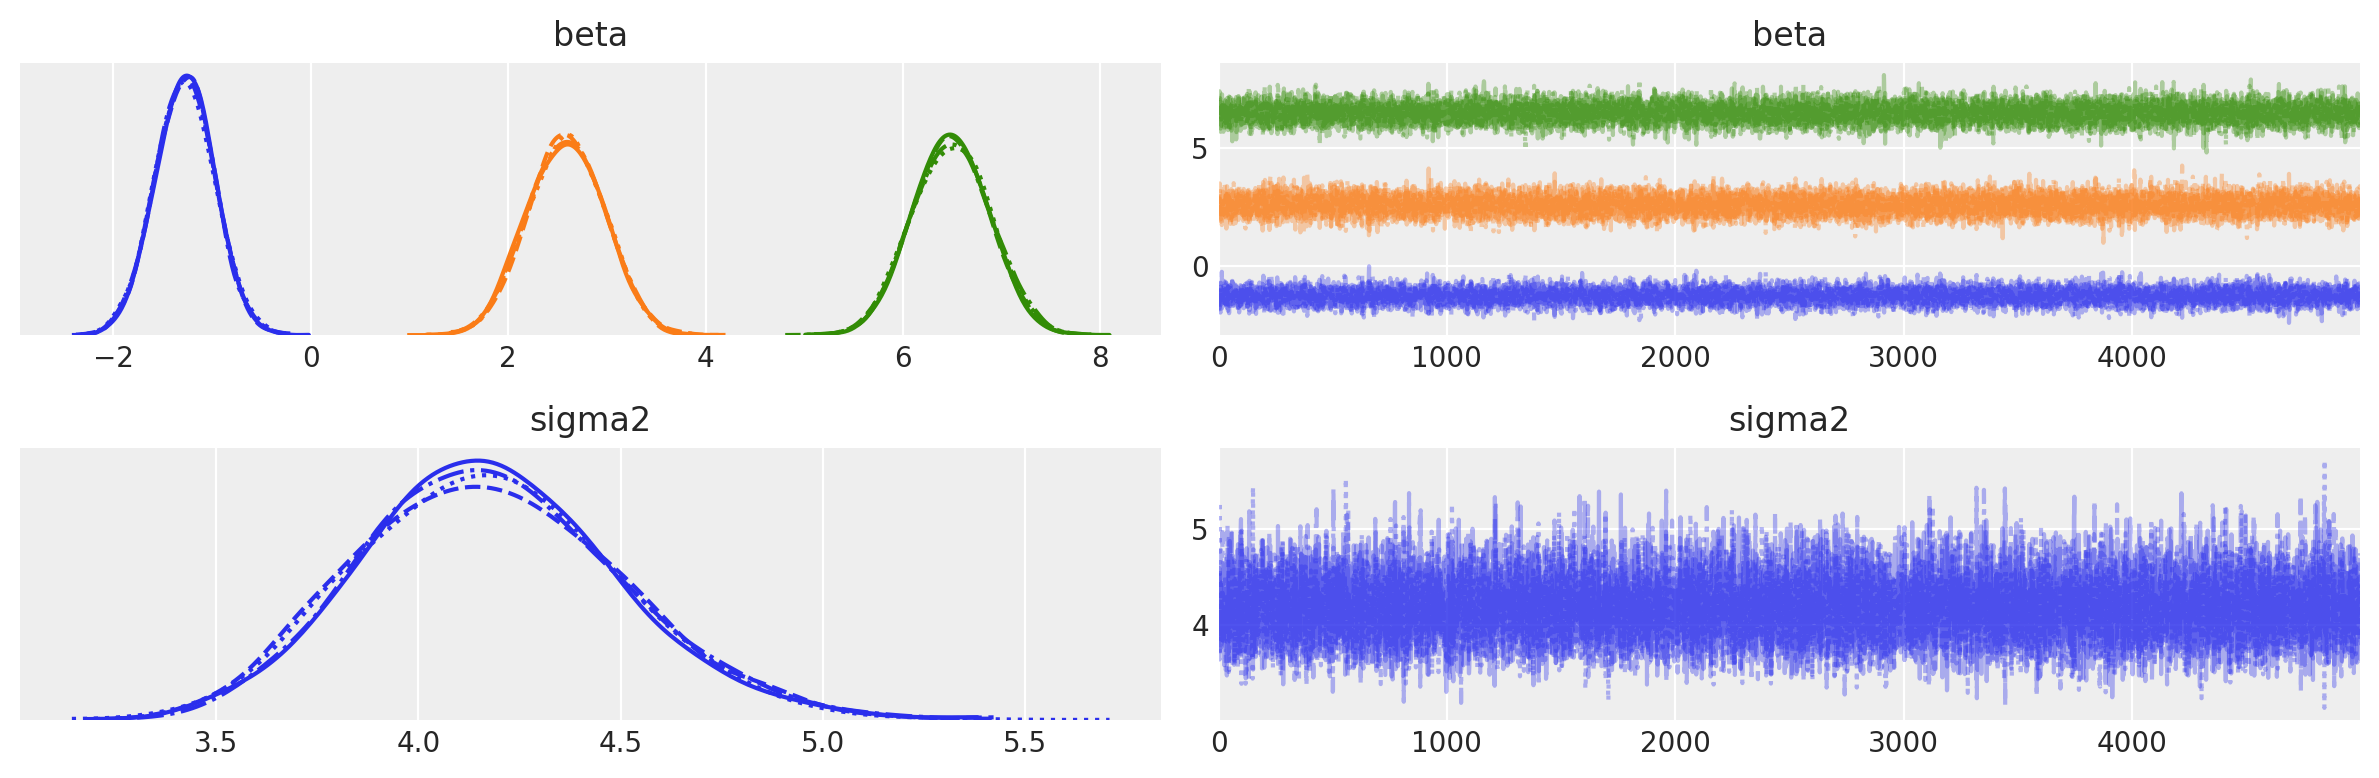

In [ ]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();
plt.savefig("traceplot.png")

In [ ]:
print(pm.summary(trace).round(2))
# print(pm.summary(trace).round(2).iloc[:,[0,1,2,3,-4,-3,-2,-1]].to_latex())

         mean    sd  hdi_3%  hdi_97%  ...   ess_sd  ess_bulk  ess_tail  r_hat
beta[0] -1.28  0.30   -1.84    -0.72  ...   8569.0    8590.0   10503.0    1.0
beta[1]  2.59  0.38    1.88     3.30  ...   9832.0    9841.0   11369.0    1.0
beta[2]  6.49  0.38    5.76     7.20  ...  10736.0   10729.0   11958.0    1.0
sigma2   4.18  0.32    3.60     4.79  ...  14823.0   15045.0   12363.0    1.0

[4 rows x 11 columns]


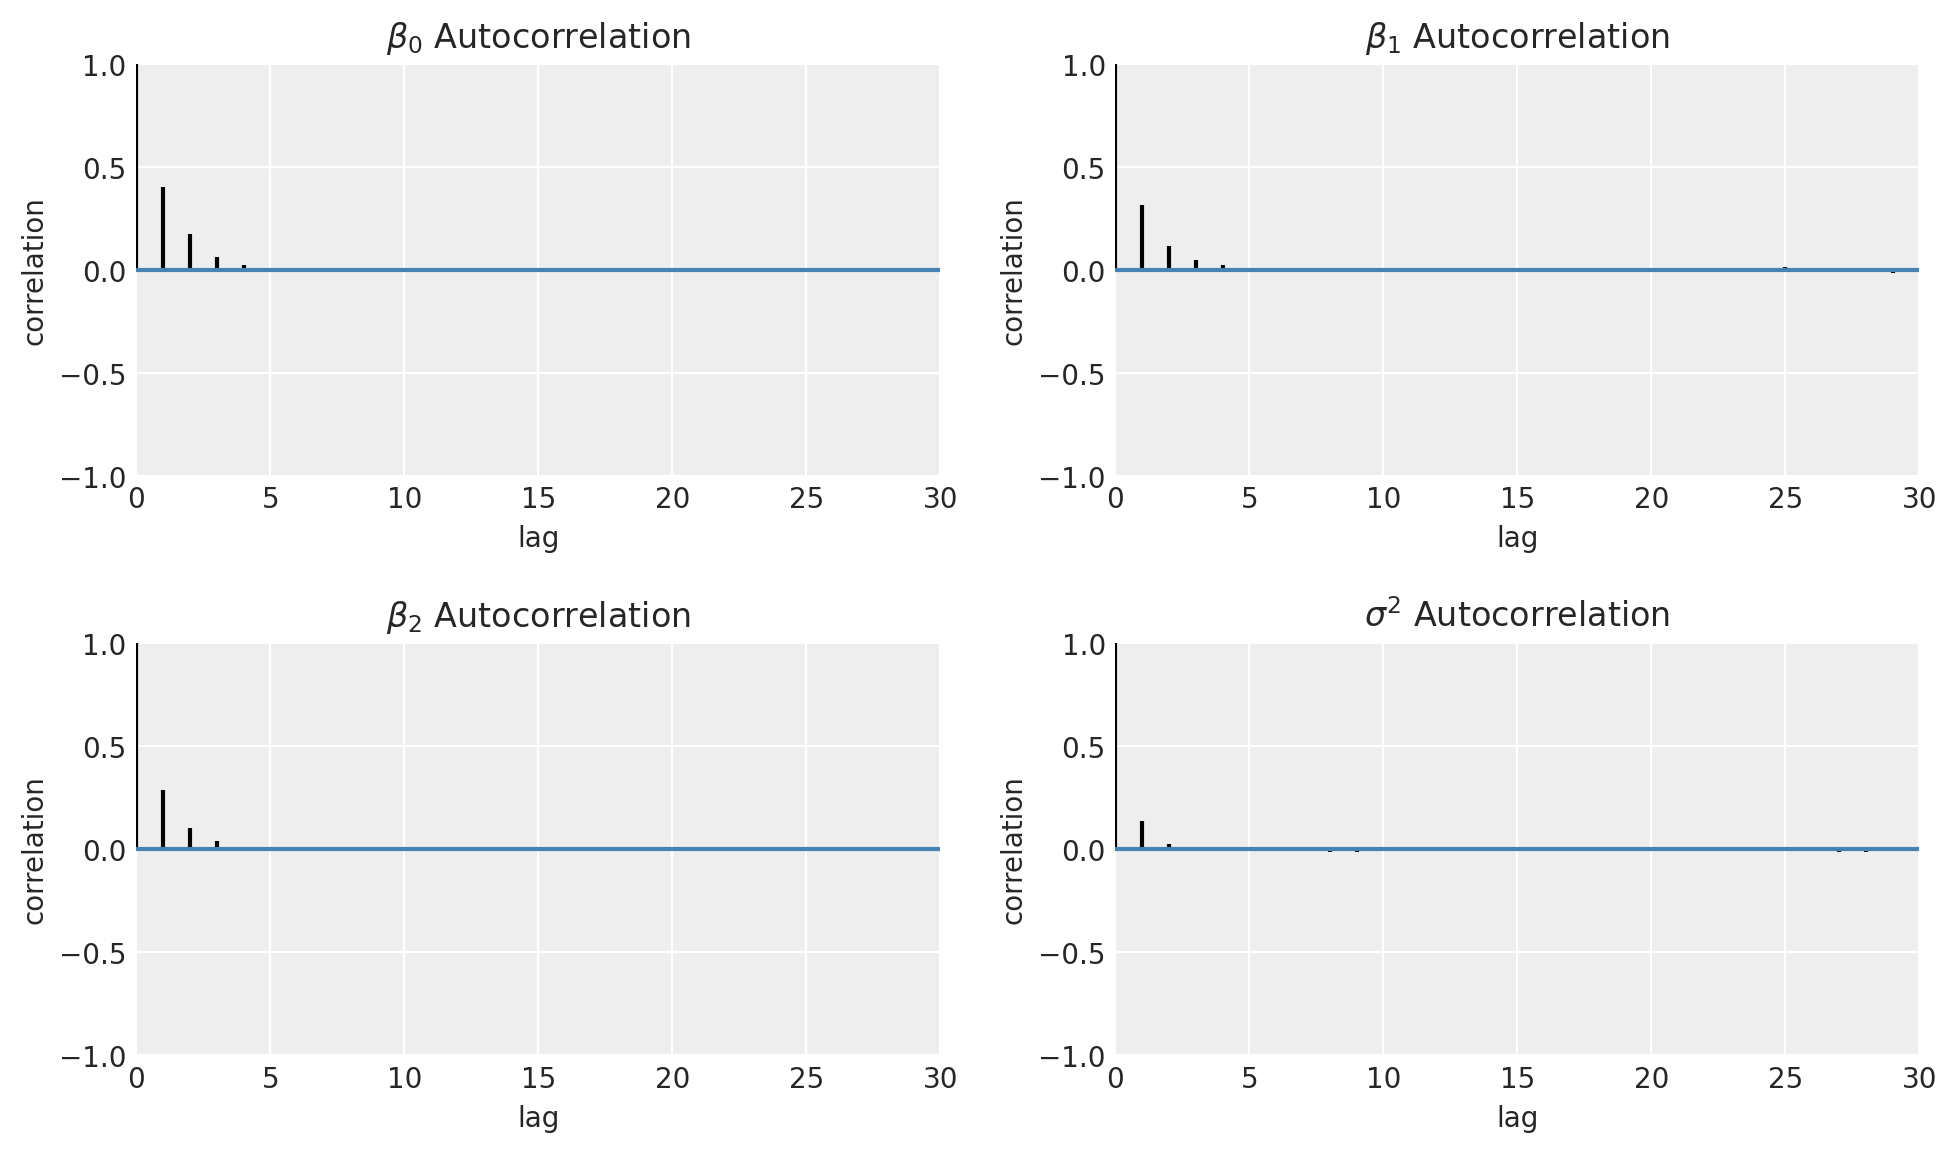

In [ ]:
import matplotlib
fig,ax = plt.subplots(2,2,figsize=(10,6))
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=10)
pm.autocorrplot(trace[beta][:,0],ax=ax[0][0],max_lag=30)
ax[0][0].set_title(r"$\beta_0$ Autocorrelation")
ax[0][0].set_xlabel("lag")
ax[0][0].set_ylabel("correlation")

pm.autocorrplot(trace[beta][:,1],ax=ax[0][1],max_lag=30)
ax[0][1].set_title(r"$\beta_1$ Autocorrelation")
ax[0][1].set_xlabel("lag")
ax[0][1].set_ylabel("correlation")

pm.autocorrplot(trace[beta][:,2],ax=ax[1][0],max_lag=30)
ax[1][0].set_title(r"$\beta_2$ Autocorrelation")
ax[1][0].set_xlabel("lag")
ax[1][0].set_ylabel("correlation")

pm.autocorrplot(trace[sigma2],ax=ax[1][1],max_lag=30)
ax[1][1].set_title(r"$\sigma^2$ Autocorrelation")
ax[1][1].set_xlabel("lag")
ax[1][1].set_ylabel("correlation")

fig.tight_layout(pad=1.5)
plt.savefig("autocorrelation1.png")

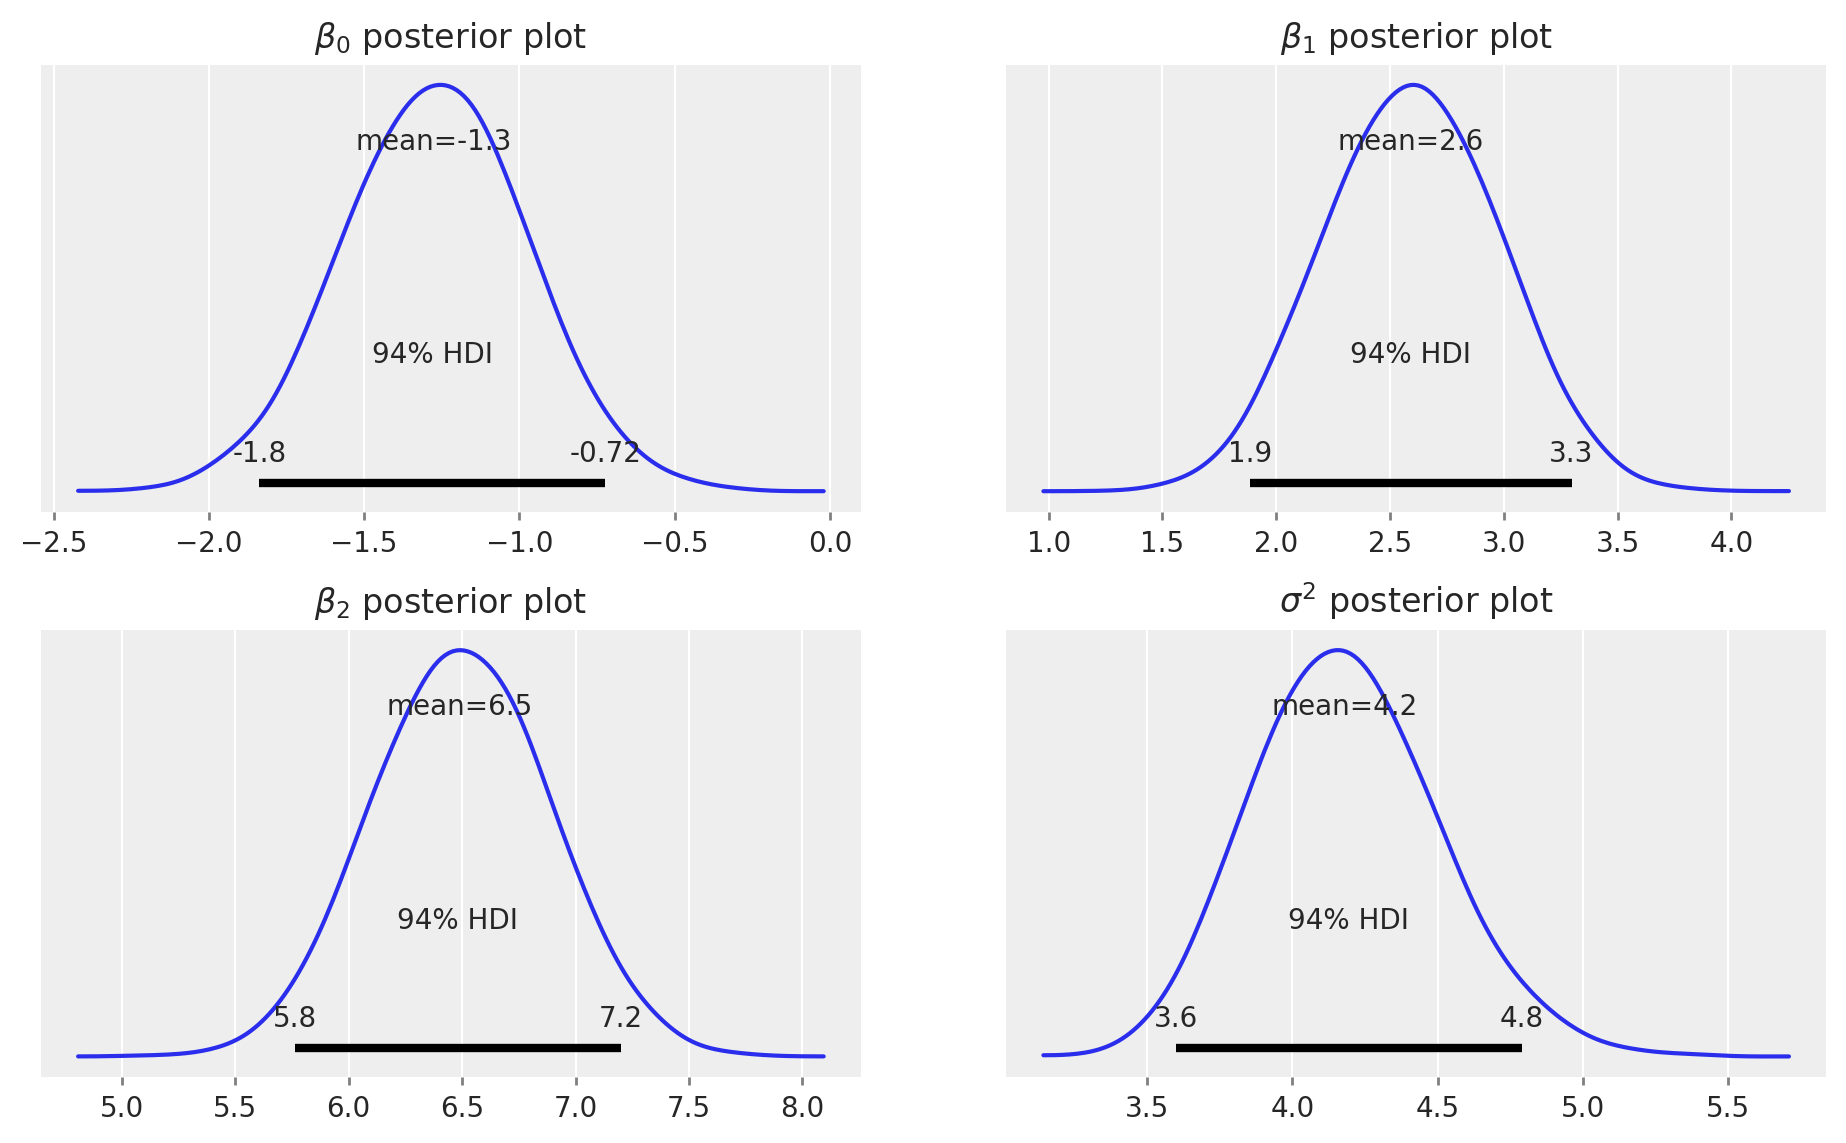

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,6))
fig.tight_layout(pad=2.5)
pm.plots.plot_posterior(trace[beta][:,0],ax=ax[0][0])
ax[0][0].set_title(r"$\beta_0$ posterior plot")

pm.plots.plot_posterior(trace[beta][:,1],ax=ax[0][1])
ax[0][1].set_title(r"$\beta_1$ posterior plot")

pm.plots.plot_posterior(trace[beta][:,2],ax=ax[1][0])
ax[1][0].set_title(r"$\beta_2$ posterior plot")

pm.plots.plot_posterior(trace[sigma2],ax=ax[1][1])
ax[1][1].set_title(r"$\sigma^2$ posterior plot");

plt.savefig("posteriori1.png")